In [13]:
!pip install inference-sdk supervision ultralytics

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from inference_sdk import InferenceHTTPClient
from ultralytics import SAM
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
import supervision as sv
import os
from google.colab import files

# Initialize models
CLIENT = InferenceHTTPClient(api_url="https://serverless.roboflow.com", api_key="lX8kapWYjAkoV9U44tAI")
sam_model = SAM("sam2_b.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Upload your image (PNG/JPG):


Saving 216-2161169_men-linen-pants-man-in-pant-shirt.png to 216-2161169_men-linen-pants-man-in-pant-shirt (2).png

Running detection...


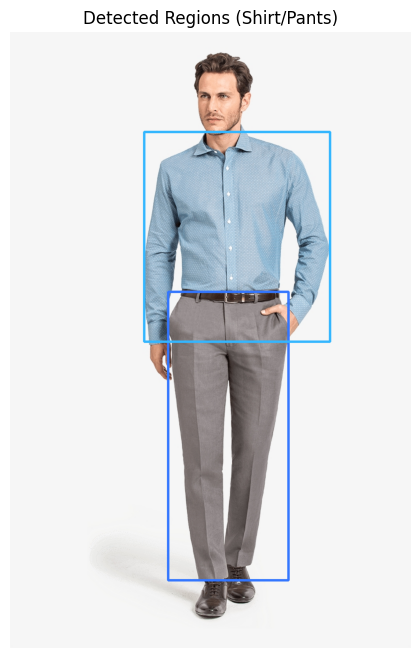


Detected classes: pants, shirt

Select region to edit (type 'shirt' or 'pants'):
pants
Selected: pants

Enter inpainting prompt (e.g., 'Stylish black leather pants'; press Enter for default): red pant
Enter negative prompt (optional, press Enter for default 'blurry, low quality'): 

image 1/1 /content/216-2161169_men-linen-pants-man-in-pant-shirt (2).png: 1024x1024 1 0, 345.3ms
Speed: 17.5ms preprocess, 345.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


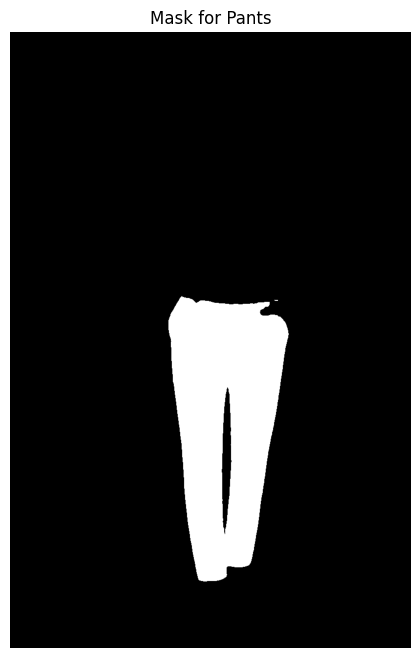

  0%|          | 0/40 [00:00<?, ?it/s]

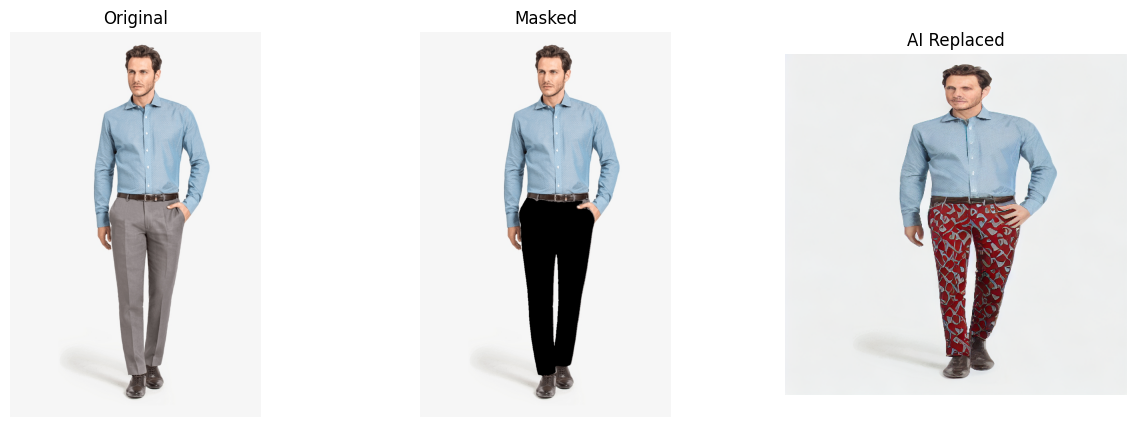

In [15]:
# Upload image
print("Upload your image (PNG/JPG):")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
with open(image_path, "wb") as f:
    f.write(list(uploaded.values())[0])

# Run detection
print("\nRunning detection...")
detection_result = CLIENT.infer(image_path, model_id="main-fashion-wmyfk/1")

# Show detections
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictions = detection_result["predictions"]
xyxy = np.array([[p["x"] - p["width"]/2, p["y"] - p["height"]/2, p["x"] + p["width"]/2, p["y"] + p["height"]/2] for p in predictions])
detections = sv.Detections(xyxy=xyxy, confidence=np.array([p["confidence"] for p in predictions]), class_id=np.array([p["class_id"] for p in predictions]))
labels = [f"{p['class']} {p['confidence']*100:.1f}%" for p in predictions]
box_annotator = sv.BoxAnnotator(thickness=3)
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
plt.figure(figsize=(8, 8))
plt.imshow(annotated_image)
plt.title("Detected Regions (Shirt/Pants)")
plt.axis("off")
plt.show()

# Check for shirt and pants
detected_classes = [p["class"].lower() for p in predictions]
print("\nDetected classes:", ", ".join(detected_classes))
has_shirt = "shirt" in detected_classes
has_pants = "pants" in detected_classes
if not (has_shirt or has_pants):
    raise ValueError("No shirt or pants detected!")

# User selection
print("\nSelect region to edit (type 'shirt' or 'pants'):")
selected_class = input().strip().lower()
if selected_class not in ["shirt", "pants"]:
    raise ValueError("Invalid input! Type 'shirt' or 'pants'.")
if (selected_class == "shirt" and not has_shirt) or (selected_class == "pants" and not has_pants):
    raise ValueError(f"No {selected_class} detected in the image!")
print(f"Selected: {selected_class}")

# User prompt
default_prompt = "Stylish black leather pants" if selected_class == "pants" else "Stylish white cotton shirt"
user_prompt = input(f"\nEnter inpainting prompt (e.g., '{default_prompt}'; press Enter for default): ").strip() or default_prompt
neg_prompt = input("Enter negative prompt (optional, press Enter for default 'blurry, low quality'): ").strip() or "blurry, low quality"

# Get bbox for selected class
selected_index = next(i for i, p in enumerate(predictions) if p["class"].lower() == selected_class)
selected_bbox = [int(predictions[selected_index]["x"] - predictions[selected_index]["width"]/2),
                int(predictions[selected_index]["y"] - predictions[selected_index]["height"]/2),
                int(predictions[selected_index]["x"] + predictions[selected_index]["width"]/2),
                int(predictions[selected_index]["y"] + predictions[selected_index]["height"]/2)]

# Segment with SAM
segment_result = sam_model(image_path, bboxes=selected_bbox)
masks = segment_result[0].masks.data.cpu().numpy()
if len(masks) == 0:
    raise ValueError("No mask generated!")
binary_mask = (masks[0] > 0.5).astype(np.uint8) * 255
mask_path = "/content/masks/selected_mask.png"
os.makedirs("/content/masks", exist_ok=True)
cv2.imwrite(mask_path, binary_mask)

# Show mask
plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap="gray")
plt.title(f"Mask for {selected_class.capitalize()}")
plt.axis("off")
plt.show()

# Inpaint
orig = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("L")
generator = torch.Generator(device=device).manual_seed(42)
inpainted = inpaint_pipe(prompt=user_prompt, negative_prompt=neg_prompt, image=orig, mask_image=mask, num_inference_steps=40, guidance_scale=7.5, generator=generator).images[0]

# Create masked image
masked = cv2.imread(image_path)
masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
masked[binary_mask > 0] = 0
masked = Image.fromarray(masked)

# Show results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(masked)
plt.title("Masked")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(inpainted)
plt.title("AI Replaced")
plt.axis("off")
plt.show()

Upload your image (PNG/JPG):


Saving ymkxgtspauoa1.jpg to ymkxgtspauoa1 (1).jpg

Running detection...


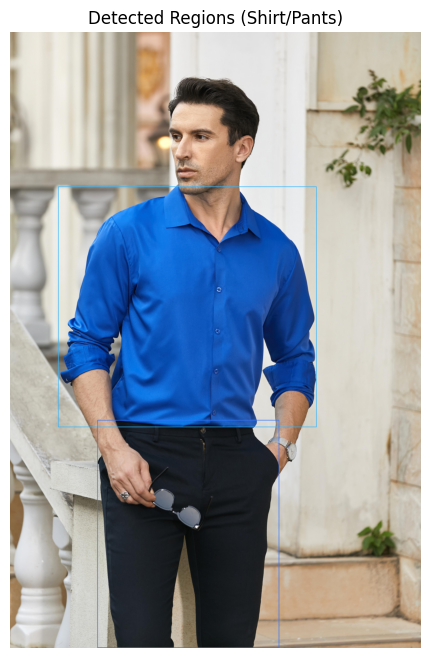


Detected classes: shirt, pants

Select region to edit (type 'shirt' or 'pants'):
shirt
Selected: shirt

Enter inpainting prompt (e.g., 'Stylish white cotton shirt'; press Enter for default): Red shirt
Enter negative prompt (optional, press Enter for default 'blurry, low quality'): dont change the face

image 1/1 /content/ymkxgtspauoa1 (1).jpg: 1024x1024 1 0, 316.7ms
Speed: 7.3ms preprocess, 316.7ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 1024)


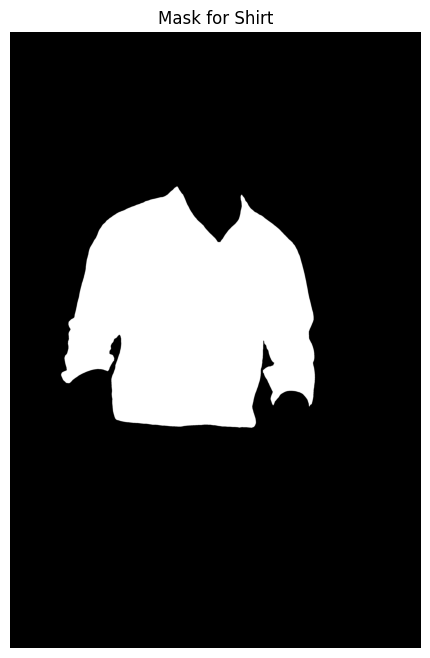

  0%|          | 0/40 [00:00<?, ?it/s]

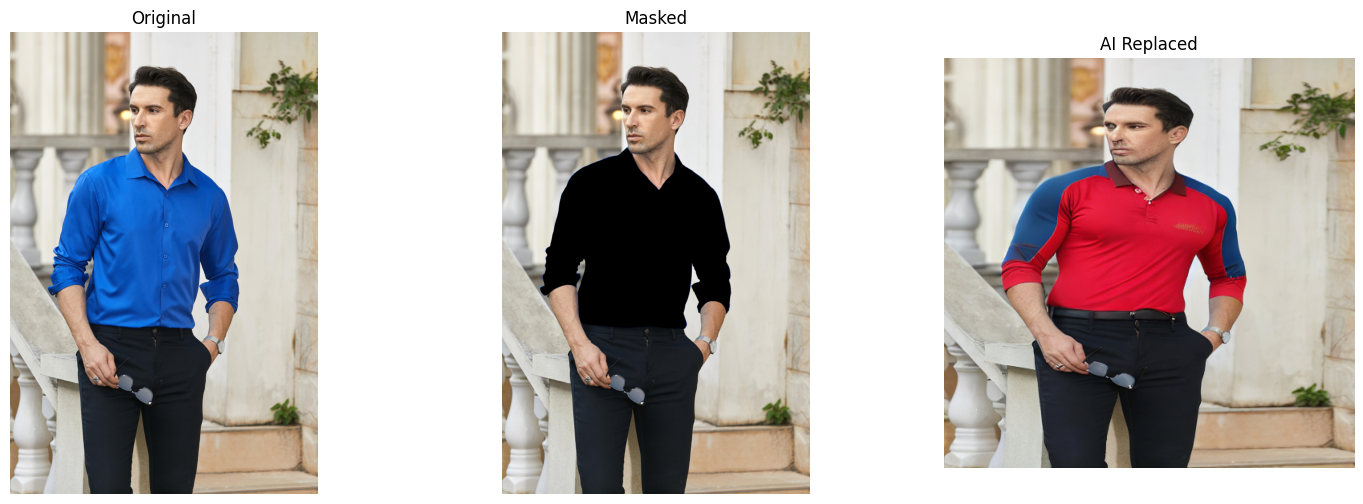

In [ ]:
# Upload image
print("Upload your image (PNG/JPG):")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
with open(image_path, "wb") as f:
    f.write(list(uploaded.values())[0])

# Run detection
print("\nRunning detection...")
detection_result = CLIENT.infer(image_path, model_id="main-fashion-wmyfk/1")

# Show detections
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictions = detection_result["predictions"]
xyxy = np.array([[p["x"] - p["width"]/2, p["y"] - p["height"]/2, p["x"] + p["width"]/2, p["y"] + p["height"]/2] for p in predictions])
detections = sv.Detections(xyxy=xyxy, confidence=np.array([p["confidence"] for p in predictions]), class_id=np.array([p["class_id"] for p in predictions]))
labels = [f"{p['class']} {p['confidence']*100:.1f}%" for p in predictions]
box_annotator = sv.BoxAnnotator(thickness=3)
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
plt.figure(figsize=(8, 8))
plt.imshow(annotated_image)
plt.title("Detected Regions (Shirt/Pants)")
plt.axis("off")
plt.show()

# Check for shirt and pants
detected_classes = [p["class"].lower() for p in predictions]
print("\nDetected classes:", ", ".join(detected_classes))
has_shirt = "shirt" in detected_classes
has_pants = "pants" in detected_classes
if not (has_shirt or has_pants):
    raise ValueError("No shirt or pants detected!")

# User selection
print("\nSelect region to edit (type 'shirt' or 'pants'):")
selected_class = input().strip().lower()
if selected_class not in ["shirt", "pants"]:
    raise ValueError("Invalid input! Type 'shirt' or 'pants'.")
if (selected_class == "shirt" and not has_shirt) or (selected_class == "pants" and not has_pants):
    raise ValueError(f"No {selected_class} detected in the image!")
print(f"Selected: {selected_class}")

# User prompt
default_prompt = "Stylish black leather pants" if selected_class == "pants" else "Stylish white cotton shirt"
user_prompt = input(f"\nEnter inpainting prompt (e.g., '{default_prompt}'; press Enter for default): ").strip() or default_prompt
neg_prompt = input("Enter negative prompt (optional, press Enter for default 'blurry, low quality'): ").strip() or "blurry, low quality"

# Get bbox for selected class
selected_index = next(i for i, p in enumerate(predictions) if p["class"].lower() == selected_class)
selected_bbox = [int(predictions[selected_index]["x"] - predictions[selected_index]["width"]/2),
                int(predictions[selected_index]["y"] - predictions[selected_index]["height"]/2),
                int(predictions[selected_index]["x"] + predictions[selected_index]["width"]/2),
                int(predictions[selected_index]["y"] + predictions[selected_index]["height"]/2)]

# Segment with SAM
segment_result = sam_model(image_path, bboxes=selected_bbox)
masks = segment_result[0].masks.data.cpu().numpy()
if len(masks) == 0:
    raise ValueError("No mask generated!")
binary_mask = (masks[0] > 0.5).astype(np.uint8) * 255
mask_path = "/content/masks/selected_mask.png"
os.makedirs("/content/masks", exist_ok=True)
cv2.imwrite(mask_path, binary_mask)

# Show mask
plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap="gray")
plt.title(f"Mask for {selected_class.capitalize()}")
plt.axis("off")
plt.show()

# Inpaint
orig = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("L")
generator = torch.Generator(device=device).manual_seed(42)
inpainted = inpaint_pipe(prompt=user_prompt, negative_prompt=neg_prompt, image=orig, mask_image=mask, num_inference_steps=40, guidance_scale=7.5, generator=generator).images[0]

# Create masked image
masked = cv2.imread(image_path)
masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
masked[binary_mask > 0] = 0
masked = Image.fromarray(masked)

# Show results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(masked)
plt.title("Masked")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(inpainted)
plt.title("AI Replaced")
plt.axis("off")
plt.show()